In [1]:
import os
from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType
from dolfinx import *
import dolfinx.fem.petsc
import ufl
import basix
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
import time
import meshio
import pyvista

### Geometry and Mesh

A $152.0~\mathrm{mm}\times 76.2~\mathrm{mm}$ gypsum plate with a single flaw

2025-05-15 00:01:46.422 (   0.724s) [    146622C3D400]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


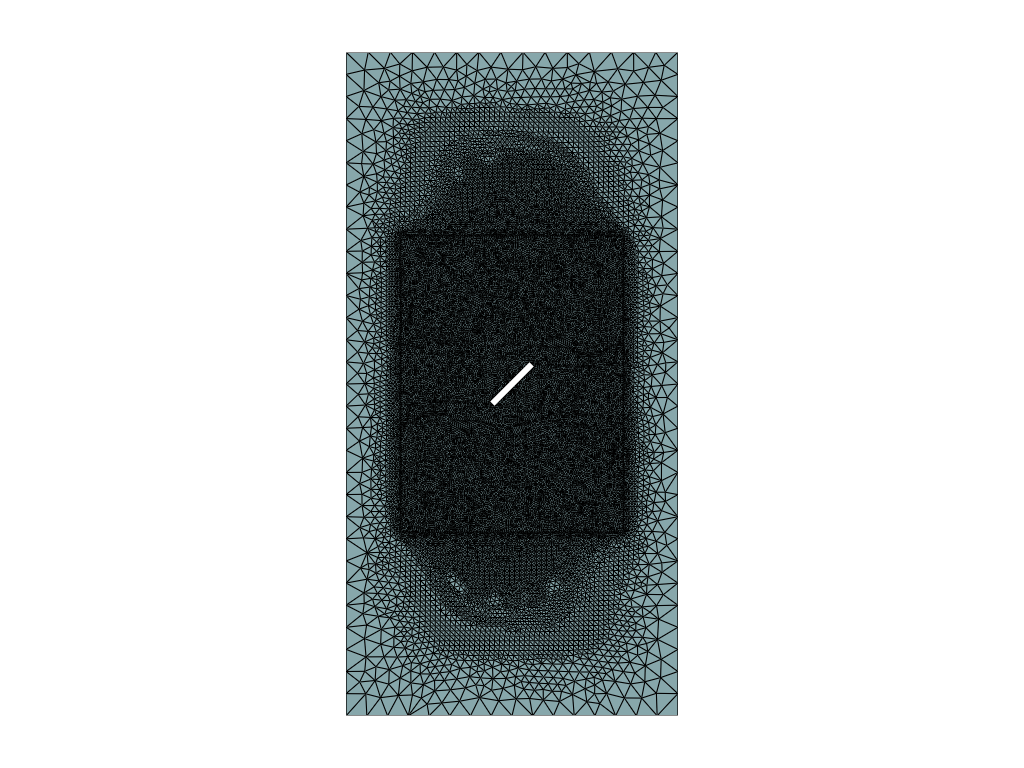

In [2]:
ndim = 2
file_name = 'plate_gypsum.xdmf'
mesh_sz = ScalarType(0.4)

comm = MPI.COMM_WORLD
comm_rank = MPI.COMM_WORLD.rank
# read mesh from file
with dolfinx.io.XDMFFile(MPI.COMM_SELF, file_name, 'r') as xdmf:
    domain = xdmf.read_mesh(name="Grid")

# visualization
topo, cells, coord = plot.vtk_mesh(domain, ndim)
grid = pyvista.UnstructuredGrid(topo, cells, coord)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.camera_position = 'xy'
plotter.show()
# # ====================================================
# # vtk_mesh for quadrilaterals plots as triangles
# # https://fenicsproject.discourse.group/t/vtk-mesh-for-quadrilaterals-plots-as-triangles/17027

### Material Properties

For linear elastic material, we assume
$$E = 6.0\times 10^{3} \mathrm{MPa},~~~ \nu = 0.15,~~~ \mathrm{plane~type = s},~~~ \mathcal{G}_c=0.016~\mathrm{N/mm}.$$

Some parameters of the cracking phase-field are defined as
$$l_0 = 2.0\mathrm{mesh~size},~~~ k=1\times 10^{-5}, ~~~ \phi_{cr} = 0.95.$$

In [3]:
# =====================================
# MATERIAL PARAMETERS
# =====================================
E = ScalarType(6.0e3)
nu = ScalarType(0.15)
plane_type = 's'
if plane_type == 's':
    mu, lmbda = E/(2.0*(1.0+nu)), E*nu/((1.0+nu)*(1.0-nu))
    E_frac = E
    kappa = (3.0-nu) / (1.0+nu)
elif plane_type == 'e':
    mu, lmbda = E/(2.0*(1.0+nu)), E*nu/((1.0+nu)*(1.0-2.0*nu))
    E_frac = E / (1.0-nu**2)
    kappa = 3.0-4.0*nu

# ==============================
# phase field parameters
# ==============================
Gc = ScalarType(0.016)
l0 = 2.0*mesh_sz
constk = ScalarType(1.0e-5)
phicr = ScalarType(0.95)
alpha = ScalarType(1.0)

### Function Spaces

Define function spaces that will be used in this problem

In [4]:
V = fem.functionspace(domain, ("CG", 1, (ndim,)))
Y = fem.functionspace(domain, ("CG", 1))
YH = fem.functionspace(domain, ("DG", 0))

### Boundary Conditions

The Dirichlet boundary conditions are applied on all four edges of the plate for displacement field. A notch boundary condition is applied in cracking phase-field

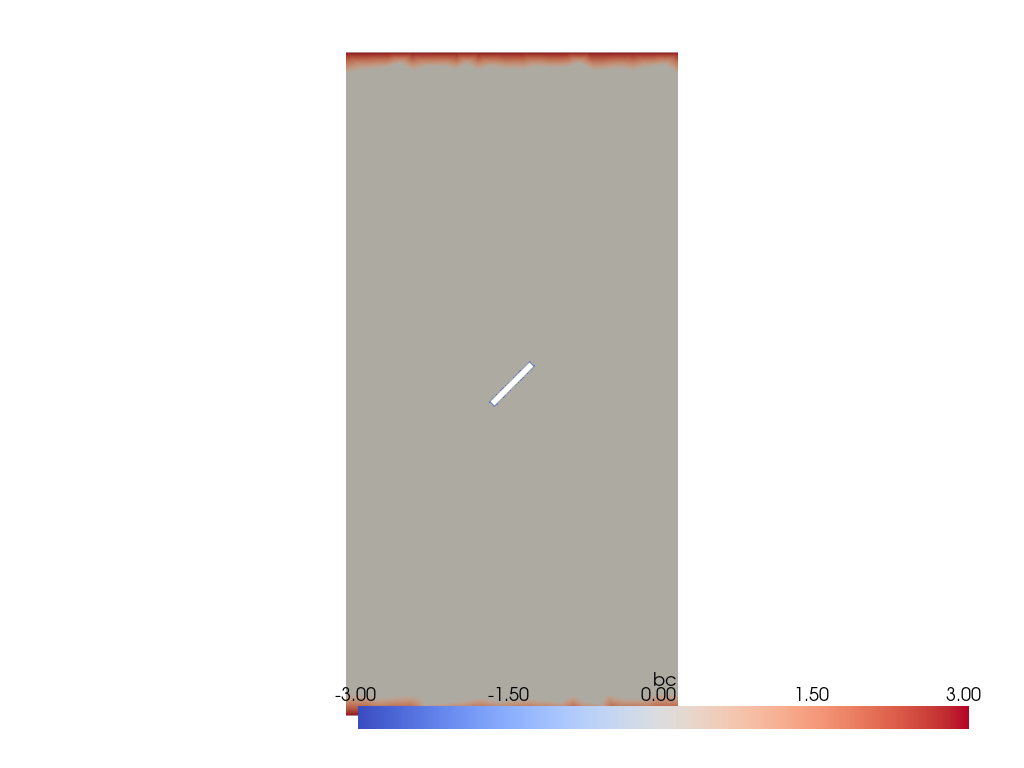

In [5]:
H_geom_max = np.max(coord[:, 1])
H_geom_min = np.min(coord[:, 1])

def up(x):
    return (np.abs(x[1] - H_geom_max) <= 0.001*mesh_sz)

def down(x):
    return (np.abs(x[1] - H_geom_min) <= 0.001*mesh_sz)

def notch(x):
    rect = np.array([[-5.0, -4.0], [-4.0, -5.0], 
                     [5.0, 4.0], [4.0, 5.0]])
    path = mpltPath.Path(rect)
    pts = np.transpose(x[:2])
    return path.contains_points(pts)

fdim = domain.topology.dim - 1
facets_u = mesh.locate_entities_boundary(domain, fdim, up)
facets_d = mesh.locate_entities_boundary(domain, fdim, down)
entity_notch = mesh.locate_entities(domain, fdim, notch)

# create a marker based on these two functions
# Concatenate and sort the arrays based on facet indices. Left facets marked with 1, right facets with two
marked_facets = np.hstack([facets_u, facets_d, entity_notch])
val_u, val_d, val_notch = 1, 2, 3
marked_values = np.hstack([np.full_like(facets_u, val_u),
                           np.full_like(facets_d, val_d),
                           np.full_like(entity_notch, val_notch)])
sorted_facets = np.argsort(marked_facets)
facet_tag = mesh.meshtags(domain, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

# identify the dofs located on the boundaries and notch
dofs_u1_u = fem.locate_dofs_topological(V.sub(1), fdim, facets_u)
dofs_u1_d = fem.locate_dofs_topological(V.sub(1), fdim, facets_d)
dofs_u0_d = fem.locate_dofs_topological(V.sub(0), fdim, facets_d)
dofs_notch = fem.locate_dofs_topological(Y, fdim, entity_notch)

uD = fem.Constant(domain, ScalarType(0.0))
bc1 = fem.dirichletbc(ScalarType(0.0), dofs_u0_d, V.sub(0))
bc2 = fem.dirichletbc(ScalarType(0.0), dofs_u1_d, V.sub(1))
bc3 = fem.dirichletbc(uD, dofs_u1_u, V.sub(1))
bcs = [bc1, bc2, bc3]
bcs_z = [fem.dirichletbc(ScalarType(1.0), dofs_notch, Y)]

# visualization the boundary conditions
node_u_u = dofs_u1_u // 2
node_u_d = dofs_u1_d // 2
node_notch = dofs_notch

plotter = pyvista.Plotter()
topo, cells, coord = plot.vtk_mesh(Y)
grid = pyvista.UnstructuredGrid(topo, cells, coord)
bc_id = np.zeros((np.shape(coord)[0],))
bc_id[node_notch] = -3
bc_id[node_u_u] = +3
bc_id[node_u_d] = +3
grid.point_data["bc"] = bc_id
plotter.add_mesh(grid, scalars="bc", cmap="coolwarm", show_edges=False)
plotter.camera_position = 'xy'
plotter.show()

### Spatial Variables
We need to define spatial variables to establish weak form from formula. We need $u_{trial}, v_{test}$ as trial and test function for displacement fields, $z_{trial}, y_{test}$ as the counterparts for phase field. In addition, we need $u_0, u, du, z_0, z, dz$ as regular functions to save displacements and cracking phase-field in Newton iterations. Internal state variables $H_0, H_1$ are also required to save the driving force in phase field formulation

In [6]:
ut = ufl.TrialFunction(V)                                                       # trial function
v = ufl.TestFunction(V)                                                         # test function
u = fem.Function(V, name='u')                                                   # displacement from previous iteration
u0 = fem.Function(V, name='u0')                                                 # displacement in last step
du = fem.Function(V, name='du')                                                 # displacement increment

zt = ufl.TrialFunction(Y)                                                       # trial function for phase field
y = ufl.TestFunction(Y)                                                         # test function for phase field
z = fem.Function(Y, name='phi')                                                 # crack phase-field
z0 = fem.Function(Y, name='phi0')                                               # crack phase-field in last step
dz = fem.Function(Y, name='dphi')                                               # crack phase-field increment

H = fem.Function(YH, name='H')                                                   # internal state variable
H1 =fem.Function(YH, name='H1')

### Weak Form Governing Equations
The weak form governing equations for displacement field and cracking phase-field write

$$\delta\Pi_u=\int_\Omega\left[H(\phi-\phi_{cr})+k\right]\sigma_{ij}\delta\epsilon_{ij}\,\mathrm{d}\Omega$$

$$\delta\Pi_\phi=\int_\Omega \frac{\pi \langle\sigma_{\theta\theta}\rangle_+^2}{E'}(\phi-2)\delta\phi +  
G_c\left[l_0\frac{\partial\phi}{\partial x_i} \frac{\partial\phi}{\partial x_i}+\frac{1}{l_0}\phi\delta\phi\right]\,\mathrm{d}\Omega$$

where $H(\bullet)$ stands for Heaviside step function, $\langle\bullet\rangle$ represents Macaulay brackets.

In [7]:
def epsilon(vv):
	return ufl.sym(ufl.grad(vv))

def sigma(vv):
    tmp = 2.0*mu*ufl.sym(ufl.grad(vv)) + lmbda*ufl.tr(ufl.sym(ufl.grad(vv)))*ufl.Identity(ndim)
    return tmp

def energy(vv):
	return 0.5 * ufl.inner(sigma(vv), epsilon(vv))

def sig_tt(vv, yy):
    gradphi = -ufl.grad(yy)
    n0 = gradphi[0] / (ufl.sqrt(ufl.inner(gradphi, gradphi)) + 1.0e-15)
    n1 = gradphi[1] / (ufl.sqrt(ufl.inner(gradphi, gradphi)) + 1.0e-15)
    local_sig = sigma(vv)
    local_sig_tt = local_sig[0, 0]*n1*n1 - 2.0*local_sig[0, 1]*n0*n1 + local_sig[1, 1]*n0*n0    
    return 0.5 * (local_sig_tt + abs(local_sig_tt))

def driving_force(vv, yy):
    coeff = ScalarType(2.0 * np.pi) / E_frac
    return ufl.conditional(ufl.And(ufl.gt(yy, ufl.exp(-alpha)), ufl.lt(yy, phicr)), 
                           coeff * sig_tt(vv, yy) * sig_tt(vv, yy), ScalarType(0.0))
	
def reduction(yy):
	return ufl.conditional(ufl.lt(yy, phicr), ScalarType(1.0), constk)	

# We set the quadrature degree for the integrals to 2 to decrease computational cost
metadata = {"quadrature_degree": 2}
dx = ufl.Measure("dx", domain=domain, metadata=metadata)
ds = ufl.Measure('ds', domain=domain,
                 subdomain_data=facet_tag, metadata=metadata)

R = reduction(z) * ufl.inner(sigma(u), epsilon(v)) * dx
Jac = ufl.derivative(R, u, ut)

R_z = (0.5*H*(z-2.0)*y + Gc*(l0*ufl.dot(ufl.grad(z), ufl.grad(y)) + 1.0/l0*z*y))*dx
Jac_z = ufl.derivative(R_z, z, zt)

### Define Output Format

In [8]:
def data_output(vtk, vv, yy, H, step):
    strain = epsilon(vv)
    stress = reduction(yy) * sigma(vv)
    
    expr1 = fem.Expression(strain[0, 0], Y.element.interpolation_points())
    expr2 = fem.Expression(strain[0, 1], Y.element.interpolation_points())
    expr3 = fem.Expression(strain[1, 1], Y.element.interpolation_points())
    e11 = fem.Function(Y, name='e11')
    e11.interpolate(expr1)
    e12 = fem.Function(Y, name='e12')
    e12.interpolate(expr2)
    e22 = fem.Function(Y, name='e22')
    e22.interpolate(expr3)
    
    expr1 = fem.Expression(stress[0, 0], Y.element.interpolation_points())
    expr2 = fem.Expression(stress[0, 1], Y.element.interpolation_points())
    expr3 = fem.Expression(stress[1, 1], Y.element.interpolation_points())
    s11 = fem.Function(Y, name='s11')
    s11.interpolate(expr1)
    s12 = fem.Function(Y, name='s12')
    s12.interpolate(expr2)
    s22 = fem.Function(Y, name='s22')
    s22.interpolate(expr3)
    
    vtk.write_function([vv, e11, e12, e22, s11, s12, s22, yy, H], step-1)


def get_disp_force(vv, yy, val_x):

    stress = reduction(yy) * sigma(vv)
    f_y = fem.assemble_scalar(fem.form(sigma(u)[1, 1] * ds(val_x)))
    f_x = fem.assemble_scalar(fem.form(sigma(u)[0, 1] * ds(val_x)))
    u_x  = fem.assemble_scalar(fem.form(vv[0] * ds(val_x)))
    u_y  = fem.assemble_scalar(fem.form(vv[1] * ds(val_x)))
    deno = fem.assemble_scalar(fem.form(1.0 * ds(val_x)))
    u_x /= deno
    u_y /= deno
    return (u_x, u_y, f_x, f_y)

### Simulations

In [ ]:
# Loading condition
uD_1_step = -5.0e-3
uD_1_step_extra = -1.0e-3
n_step = 2000
iprint = 20
critical_step = 541

# set the initial conditions
u.x.array[:] = 0.0
u0.x.array[:] = 0.0
du.x.array[:] = 0.0
fem.petsc.set_bc(u.x.petsc_vec, bcs)

z.x.array[:] = 0.0
z0.x.array[:] = 0.0
dz.x.array[:] = 0.0
fem.petsc.set_bc(z.x.petsc_vec, bcs_z)

H.x.array[:] = 0.0

J_fem = fem.form(Jac)
R_fem = fem.form(R)
A = dolfinx.fem.petsc.create_matrix(J_fem)
L = dolfinx.fem.petsc.create_vector(R_fem)
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)

J_z_fem = fem.form(Jac_z)
R_z_fem = fem.form(R_z)
A_z = dolfinx.fem.petsc.create_matrix(J_z_fem)
L_z = dolfinx.fem.petsc.create_vector(R_z_fem)
solver_z = PETSc.KSP().create(domain.comm)
solver_z.setOperators(A_z)

files = os.listdir('./')
file_del = []
for x in files:
    if (x[-3:] == 'vtu') or (x[-3:] == 'vtk'):
        file_del.append(x)
for x in file_del:
    os.remove(x)
vtk = dolfinx.io.VTKFile(domain.comm, "phase_field.vtk", "w")
f_log = "./running_log.dat"
with open(f_log, "w+") as f:
    pass
f_bou = './u_P.dat'
with open(f_bou, "w+") as f:
    f.write("#      ux        uy         Px        Py\n")
t0 = time.time()
uD_hist = 0.0
for istep in range(1, n_step+1):
    with open(f_log, "a") as f:
        f.write("Running...%5d/%5d\n" % (istep, n_step))
    if istep == critical_step:
        uD_1_step = uD_1_step_extra

    uD_hist = uD_hist + uD_1_step
    uD.value = uD_hist

    # Staggered Scheme
    tol = 1.0e-8
    n_iter = 0
    max_iter = 50
    while True:
        # =========================================================================
        #       DISPLACEMENT FIELD SOLVER
        # =========================================================================
        # ---------- Assemble stiffness matrix A
        A.zeroEntries()
        dolfinx.fem.petsc.assemble_matrix(A, J_fem, bcs=bcs)
        A.assemble()
        # ---------- Assemble residual vector R
        with L.localForm() as loc_L:
            loc_L.set(0.0)
        dolfinx.fem.petsc.assemble_vector(L, R_fem)
        L.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        L.scale(-1.0)
        # ---------- Compute Dirichlet BC: L - J(u_D-u_(i-1))
        dolfinx.fem.petsc.apply_lifting(L, [J_fem], [bcs], x0=[u.x.petsc_vec])
        # Set du|_bc = u_{i-1}-u_D
        dolfinx.fem.petsc.set_bc(L, bcs, u.x.petsc_vec, 1.0)
        L.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES, mode=PETSc.ScatterMode.FORWARD)
        # Solve linear problem
        du.x.array[:] = 0.0
        solver.solve(L, du.x.petsc_vec)
        du.x.scatter_forward()
        # Update u_{i+1} = u_i + delta u_i
        u.x.array[:] += du.x.array
        
        # =========================================================================
        #       UPDATE HISTORICAL VARIABLE H
        # =========================================================================
        expr = fem.Expression(driving_force(u, z), YH.element.interpolation_points())
        H1.interpolate(expr)
        ind = np.where(H1.x.array[:] > H.x.array[:])
        H.x.array[ind] = H1.x.array[ind]
        
        # =========================================================================
        #       CRACK PHASE-FIELD SOLVER
        # =========================================================================
        # ---------- Assemble stiffness matrix A
        A_z.zeroEntries()
        dolfinx.fem.petsc.assemble_matrix(A_z, J_z_fem, bcs=bcs_z)
        A_z.assemble()
        # ---------- Assemble residual vector R
        with L_z.localForm() as loc_L_z:
            loc_L_z.set(0.0)
        dolfinx.fem.petsc.assemble_vector(L_z, R_z_fem)
        L_z.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        L_z.scale(-1.0)
        # Compute b - J_z(z_D-z_{i-1})
        dolfinx.fem.petsc.apply_lifting(L_z, [J_z_fem], [bcs_z], x0=[z.x.petsc_vec])
        # # Set dz|_bc = z_{i-1} - z_D
        dolfinx.fem.petsc.set_bc(L_z, bcs_z, z.x.petsc_vec, 1.0)
        L_z.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES, mode=PETSc.ScatterMode.FORWARD)
        # Solve linear problem
        dz.x.array[:] = 0.0
        solver_z.solve(L_z, dz.x.petsc_vec)
        dz.x.scatter_forward()
        # ind = np.where(dz.x.array[:] < 0.0)
        # dz.x.array[ind] = 0.0
        z.x.array[:] += dz.x.array[:]
        ind = np.where(z.x.array[:] > 1.0)
        z.x.array[ind] = 1.0
        ind = np.where(z.x.array[:] < 0.0)
        z.x.array[ind] = 0.0

        # =====================================================
        #            Residual control convergence check 
        # =====================================================
        # if n_iter > 0:
        #     err_u_i = L.norm() / norm_L0
        #     with open(f_log, "a") as f:
        #         f.write("    Newton-Raphson iteration %5d, err: %6.3e\n" % (n_iter, err_u_i))
        #     # print("    Newton-Raphson iteration %5d, err: %6.3e" % (n_iter, err_u_i))
        #     if err_u_i < tol:
        #         with open(f_log, "a") as f:
        #             f.write("    Newton-Raphson iteration converged.\n")
        #         # print("    Newton-Raphson iteration converged.")
        #         break
        #     if n_iter == max_iter:
        #         with open(f_log, "a") as f:
        #             f.write("    Newton-Raphson iteration reached its maximum.\n")
        #         # print("    Newton-Raphson iteration reached its maximum.")
        #         break
        # else:
        #     norm_L0 = L.norm()  
        # =====================================================
        #            Displacement control convergence check 
        # =====================================================
        if n_iter > 0:
            err_u_i = du.x.petsc_vec.norm(1) / (norm_du0 + 1.0e-15)
            with open(f_log, "a") as f:
                f.write("    Newton-Raphson iteration %5d, err: %6.3e\n" % (n_iter, err_u_i))
            # print("    Newton-Raphson iteration %5d, err: %6.3e" % (n_iter, err_u_i))
            if err_u_i < tol:
                with open(f_log, "a") as f:
                    f.write("    Newton-Raphson iteration converged.\n")
                # print("    Newton-Raphson iteration converged.")
                break
            if n_iter == max_iter:
                with open(f_log, "a") as f:
                    f.write("    Newton-Raphson iteration reached its maximum.\n")
                # print("    Newton-Raphson iteration reached its maximum.")
                break
        else:
            norm_du0 = du.x.petsc_vec.norm(1)   
        # =====================================================
        n_iter += 1
    if (comm_rank==0) and ( (np.mod(istep, iprint) == 0) or (istep == 1) ):
        data_output(vtk, u, z, H, istep)
        [u_x, u_y, f_x, f_y] = get_disp_force(u, z, val_u)
        with open(f_bou, "a") as f:
            f.write("%6.3e %6.3e %6.3e %6.3e\n" % (u_x, u_y, f_x, f_y))
        t1 = time.time()
        print("Current step is %5d, elapsed time is %6.3e" % (istep, t1-t0))
        t0 = time.time()

Current step is     1, elapsed time is 2.505e+01
Current step is    20, elapsed time is 4.681e+02
Current step is    40, elapsed time is 4.624e+02
Current step is    60, elapsed time is 5.012e+02
